In [ ]:
!pip install PersianStemmer
!pip install transformers
!pip install https://github.com/htaghizadeh/PersianStemmer-Python/archive/master.zip --upgrade
!pip install hazm
!pip install demoji

In [ ]:
from google.colab import drive
import sys
drive.mount('/content/drive')
sys.path.insert(0, '/content/drive/My Drive/modules') #Adds preprocessing module to current session.

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
import preprocess
import numpy as np
import tensorflow as tf
import demoji
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Embedding
from keras.layers import Dropout
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
demoji.download_codes()
np.random.seed(42)
tf.random.set_seed(42)

In [ ]:
def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

In [ ]:
def create_vector_from_data(train_data_df, test_data_df):

  train_sentence_list = [row.sentence for index, row in train_data_df.iterrows()]
  train_labels_list = [row.label for index, row in train_data_df.iterrows()]

  tokenizer = Tokenizer(oov_token='<UNK>')
  tokenizer.fit_on_texts(train_sentence_list)
  train_sequences = tokenizer.texts_to_sequences(train_sentence_list)
  maxlen = max([len(x) for x in train_sequences])
  train_padded = pad_sequences(train_sequences, padding='post', truncating='post', maxlen=maxlen)

  test_sentence_list = [row.sentence for index, row in test_data_df.iterrows()]  
  test_labels_list = [row.label for index, row in test_data_df.iterrows()]
  test_sequences = tokenizer.texts_to_sequences(test_sentence_list)
  test_padded = pad_sequences(test_sequences, padding='post', truncating='post', maxlen=maxlen)
  return train_padded, train_labels_list, test_padded, test_labels_list, len(tokenizer.word_index)+1, maxlen

In [ ]:
train_ds = pd.read_csv('/content/drive/MyDrive/data/silver_dataset.csv')
train_ds = preprocess.auto_preprocess(dataframe=train_ds, stop_words_type='custom', stemming = False)

test_ds = pd.read_csv('/content/drive/MyDrive/data/gold_dataset.csv')
test_ds = preprocess.auto_preprocess(dataframe=test_ds, stop_words_type='custom', stemming = False)

In [ ]:
train_vectors, train_labels_list, test_vectors, test_labels_list, vocab_size, maxlen = create_vector_from_data(train_data_df=train_ds, test_data_df=test_ds)

In [ ]:
train_dataset = tf.data.Dataset.from_tensor_slices((train_vectors, train_labels_list))
train_data = train_dataset.shuffle(100).batch(32)
test_dataset = tf.data.Dataset.from_tensor_slices((test_vectors, test_labels_list))
test_data = test_dataset.batch(64)

In [ ]:
checkpoint_filepath = './'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)
model = Sequential()
model.add(Embedding(input_dim=vocab_size,output_dim=300, input_length=maxlen))
model.add(Conv1D(filters=64, kernel_size=2, activation='relu'))
model.add(MaxPooling1D(pool_size=3))
model.add(Flatten())
model.add(Dense(10, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
print(model.summary())
opt = keras.optimizers.Adam(learning_rate=0.001)
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
history = model.fit(train_data, epochs=4, validation_data = test_data, callbacks=[model_checkpoint_callback])


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 110, 300)          3467100   
_________________________________________________________________
conv1d (Conv1D)              (None, 109, 64)           38464     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 36, 64)            0         
_________________________________________________________________
flatten (Flatten)            (None, 2304)              0         
_________________________________________________________________
dense (Dense)                (None, 10)                23050     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 11        
Total params: 3,528,625
Trainable params: 3,528,625
Non-trainable params: 0
______________________________________________

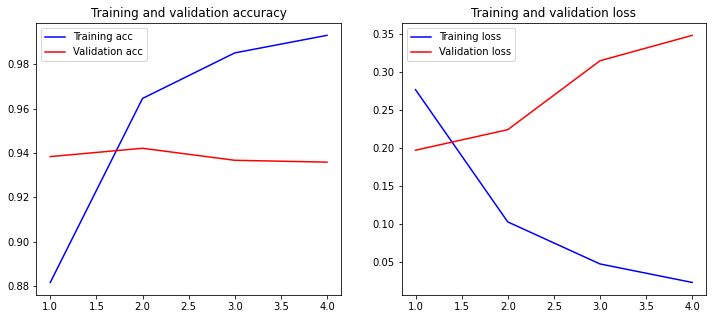

In [ ]:
plot_history(history)

In [ ]:
# keras.utils.plot_model(model)

In [ ]:
model.load_weights(checkpoint_filepath)

In [ ]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

In [ ]:
# results = model.predict_classes(test_data)
results = (model.predict(test_data) > 0.5).astype("int32")

In [ ]:
f1 = (f1_score(test_labels_list,results ))*100
f1 = round(f1,2)
print('f1 score is: ',f1)

accuracy = (accuracy_score(test_labels_list,results ))*100
accuracy = round(accuracy,2)
print('accuracy score is: ',accuracy)

precision = (precision_score(test_labels_list,results ))*100
precision = round(precision,2)
print('precision score is: ',precision)

recall = (recall_score(test_labels_list,results ))*100
recall = round(recall,2)
print('recall score is: ',recall)

f1 score is:  94.3
accuracy score is:  94.21
precision score is:  92.89
recall score is:  95.75
